# Implicit performance improvements when plotting raster data

This notebook illustrates how performant rendering (enabled by default) is achieved in `spatialdata-plot` when rendering images/labels and what to consider when plotting multiscale-images/-labels. A heuristic approach is used to achieve fast rendering times, however, there are multiple ways to change the default behavior.

Furthermore, this notebook demonstrates how the rendering of points and shapes can be sped up by using the datashader backend.

The example dataset for image/label rendering can be downloaded here: [Visium dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/visium_associated_xenium_io.zip). Please rename the file to `visium.zarr` and place it in the same folder as this notebook (or use symlinks to make the data accessible).

* [1 Single-Scale Images](#1-single-scale-images)
    * [1.1 Default Behavior](#11-default-behavior)
    * [1.2 Options](#12-options)
* [2 Multi-Scale Images](#2-multi-scale-images)
    * [2.1 Default Behavior](#21-default-behavior)
    * [2.2 Options](#22-options)
* [3 Datashader Support for Shapes and Points](#3-datashader-support-for-shapes-and-points)
    * [3.1 Polygons](#31-polygons)
    * [3.2 Multi-Polygons](#32-multi-polygons)
    * [3.3 Circles](#33-circles)
    * [3.4 Points](#34-points)

In [1]:
import timeit
import warnings

import dask
dask.config.set({"dataframe.query-planning": False})

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datashader as ds
import scanpy as sc
import spatialdata as sd
import spatialdata_plot as sdp
from geopandas import GeoDataFrame
from shapely.affinity import translate
from shapely.geometry import MultiPolygon, Polygon
from spatialdata._core.spatialdata import SpatialData
from spatialdata.models import Image2DModel, Labels2DModel, PointsModel, ShapesModel

warnings.filterwarnings("ignore")


for p in [sd, sdp, sc, ds]:
    print(f"{p.__name__}: {p.__version__}")

/Users/tim.treis/anaconda3/envs/spatialdata/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:21: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/Users/tim.treis/anaconda3/envs/spatialdata/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


spatialdata: 0.2.2
spatialdata_plot: 0.2.7.dev17+ga2b66e1
scanpy: 1.10.2
datashader: 0.16.3


In [2]:
sdata = sd.read_zarr("visium.zarr")
sdata

SpatialData object, with associated Zarr store: /Users/tim.treis/Documents/GitHub/spatialdata-notebooks/notebooks/examples/visium.zarr
├── Images
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': DataTree[cyx] (3, 21571, 19505), (3, 10785, 9752), (3, 5392, 4876), (3, 2696, 2438), (3, 1348, 1219)
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_hires_image': DataArray[cyx] (3, 2000, 1809)
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_lowres_image': DataArray[cyx] (3, 600, 543)
├── Shapes
│     └── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (4992, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (4992, 18085)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_hires_image (Images), CytAssist_FFPE_Human_Breast_Cancer (Shapes)
    ▸ 'downscaled_lowres', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_lowres_image (Images), CytAssist_FFPE_Human_Breast_Cancer (Shapes)
    ▸ 'global', with elements:
  

## 1 Single-Scale Images

A single-scale image is a simple, single image with values in a grid. On the other hand, a `SpatialData` object can include multi-scale images that are composed of multiple single-scale images at different scales. All of those single-scale images show the same picture, just at different resolutions (the underlying grids differ). Therefore, one single-scale image can include more details when plotted compared to another single-scale image belonging to the same multi-scale image while having a larger size and higher rendering times.

An image or label can either be single- or multi-scale and the rendering process differs slightly. For a multi-scale image or label, one of the single scales has to be chosen initially in order to get a renderable image which is then treated like a single-scale image. For a single-scale image, one does not have the option to select a scale, but decreasing the resolution in order to increase the runtime is still possible by downsampling the image.

### 1.1 Default Behavior

INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              
INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    
CPU times: user 144 ms, sys: 19.4 ms, total: 163 ms
Wall time: 206 ms


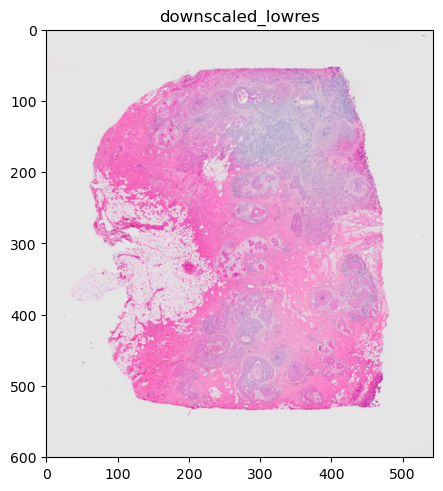

In [3]:
%%time
sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_lowres_image").pl.show()

When necessary, the image is rasterized to improve performance. Here, the image is downsampled which leads to a lower resolution. This is especially important when the size of the rendering device is smaller than the size of the image to render. In this case, rendering the full image instead of the rasterized one would not lead to a better result while having longer rendering times. Under the hood, a heuristic using image extent, dpi and size of the rendering device determines the necessity of rasterization.

INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              
INFO     Rasterizing image for faster rendering.                                                                   
CPU times: user 120 ms, sys: 14.8 ms, total: 135 ms
Wall time: 134 ms


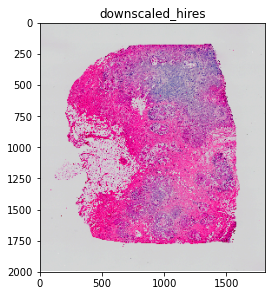

In [4]:
%%time
sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_hires_image").pl.show()
# the image is automatically rasterized before rendering

### 1.2 Options

The user can set image size and dpi with the `dpi` and `figisze` parameters of `pl.show()`. These parameters also have an influence on the rasterization! For example, if an image is automatically rasterized, because its size is larger than that of the rendering device, the rasterization is not performed anymore after the `figsize` is increased to a value larger than the image size. The reason for this is that `dpi` and `figsize` are part of the heuristic that is used to decide if rasterization is necessary.

INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              
INFO     Rasterizing image for faster rendering.                                                                   
CPU times: user 229 ms, sys: 15.7 ms, total: 245 ms
Wall time: 244 ms


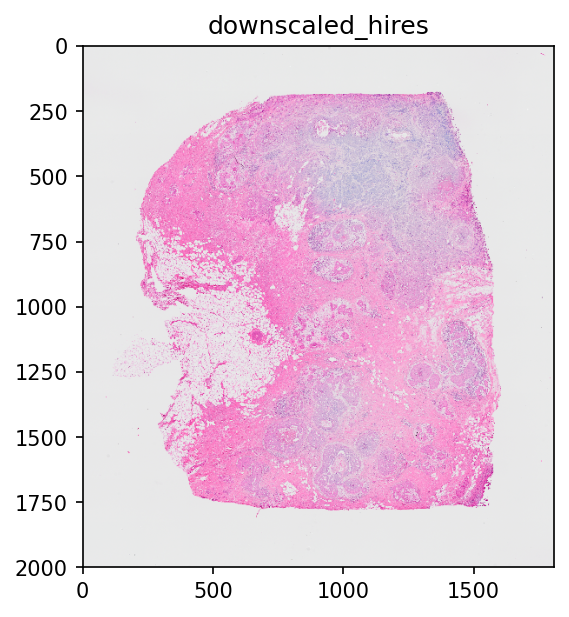

In [5]:
%%time
sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_hires_image").pl.show(dpi=150)
# the image is automatically rasterized before rendering

One can also alter the `dpi` and `figsize` parameters in `plt.figure()` or `plt.subplots()` which can be seen in the following.

INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              
INFO     Rasterizing image for faster rendering.                                                                   
CPU times: user 98.2 ms, sys: 13.3 ms, total: 112 ms
Wall time: 146 ms


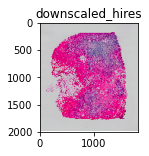

In [6]:
%%time
fig, axs = plt.subplots(ncols=1, figsize=(2, 2))
sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_hires_image").pl.show(ax=axs)

In order to disable the rasterization of an image, one can set `scale="full"` in `pl.render_images()` or `pl.render_labels()`. Note, that depending on the image size, this can lead to long rendering times. In this case, the image size is not large enough to lead to a "too long" runtime. See a more drastic effect of disabling the rasterization in part 2 (the multi-scale image contains a larger image).

INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              
CPU times: user 109 ms, sys: 30.2 ms, total: 139 ms
Wall time: 138 ms


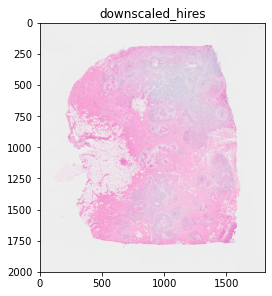

In [7]:
%%time
sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_hires_image", scale="full").pl.show()

## 2 Multi-Scale Images

### 2.1 Default Behavior

Per default, the scale that fits the size of the rendering device best is automatically selected. From there on, the selected scale is treated like a single-scale image (e.g. if necessary, a rasterization step is added to speed up the rendering process).

In the example here: `scale4` (the scale with the lowest resolution) was automatically selected.

CPU times: user 125 ms, sys: 41.1 ms, total: 166 ms
Wall time: 138 ms


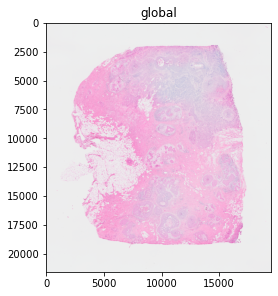

In [8]:
%%time
sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_full_image").pl.show("global")
# "scale4" is automatically selected

### 2.2 Options

As always, image size and dpi can be regulated via the `dpi` and `figsize` parameters of `pl.show()`. Those parameters also affect the scale selection!

The example below shows that when choosing a higher `dpi`, a scale with higher resolution is selected automatically (`scale3` in this case). Also, a rasterization step was performed to speed up the performance (just as it would happen with a single-scale image). It is the normal behavior that when the "optimal" scale lies between two existing scales, the one with higher resolution is selected and if necessary, the image is rasterized to speed up the rendering. Else, the resulting resolution could be lower than the "optimal" one.

The same behavior could have been achieved with e.g. `dpi=300`.

CPU times: user 121 ms, sys: 39 ms, total: 160 ms
Wall time: 134 ms


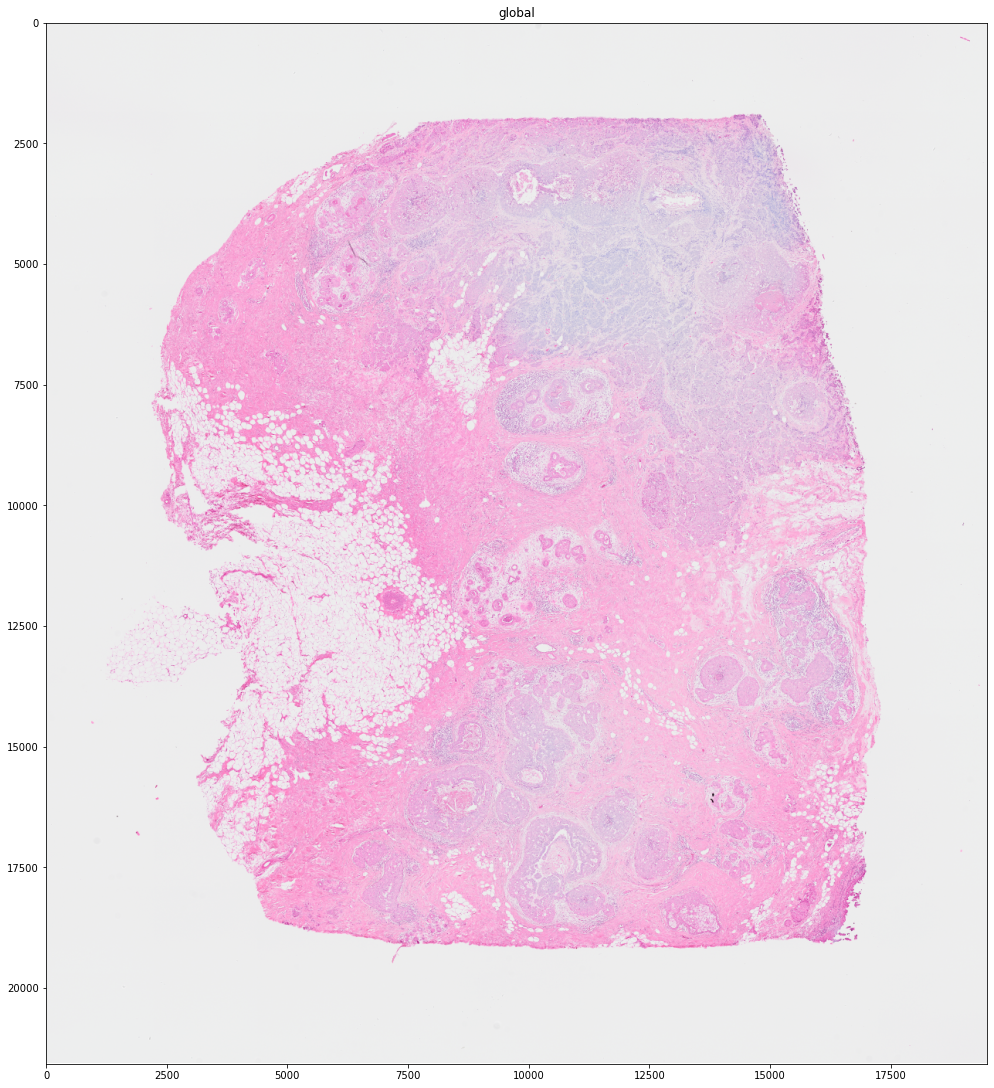

In [9]:
%%time
sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_full_image").pl.show("global", figsize=(15.0, 15.0))
# "scale3" is automatically selected and the image is automatically rasterized before rendering

The user can also select a specific scale to be rendered using the `scale` argument of `pl.render_images()` or `pl.render_labels()`.

Note, that when a specific scale is selected, no rasterization will be performed, unless: `dpi` or `figsize` are specified by the user in `pl.show()`. This re-enables the rasterization if neccessary.

CPU times: user 298 ms, sys: 155 ms, total: 453 ms
Wall time: 367 ms


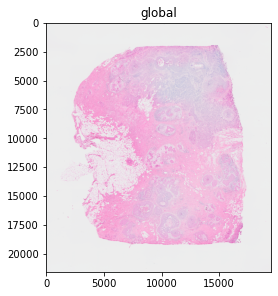

In [10]:
%%time
sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_full_image", scale="scale3").pl.show("global")

INFO     Rasterizing image for faster rendering.                                                                   
CPU times: user 4.35 s, sys: 216 ms, total: 4.57 s
Wall time: 3.31 s


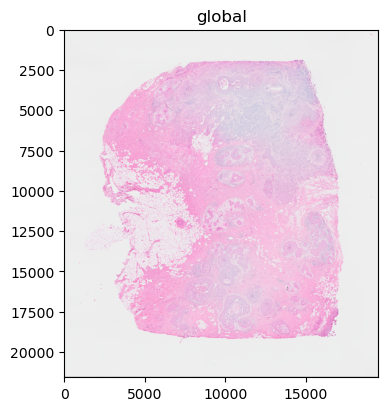

In [11]:
%%time
sdata.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_full_image", scale="scale3").pl.show("global", dpi=100)
# the image is automatically rasterized before rendering

Below, you can see an example where the scale with the highest resolution was selected but the overall plot should have a `dpi` of 100. This leads to a drastic rasterization which is computationally demanding, which exemplifies that care should be taken when specifing both scale and dpi/figsize at the same time. Here plotting from a lower scale and leaving the `dpi` parameter to its default value would have led to plot with comparable image quality but faster rendering time. Note that we plot a cropped version of the data to reduce the notebook execution time.

In [12]:
sdata_cropped = sdata.query.bounding_box(
    min_coordinate=[0, 0], max_coordinate=[10000, 10000], axes=("x", "y"), target_coordinate_system="global"
)

INFO     Rasterizing image for faster rendering.                                                                   
CPU times: user 3.35 s, sys: 2.13 s, total: 5.48 s
Wall time: 3.79 s


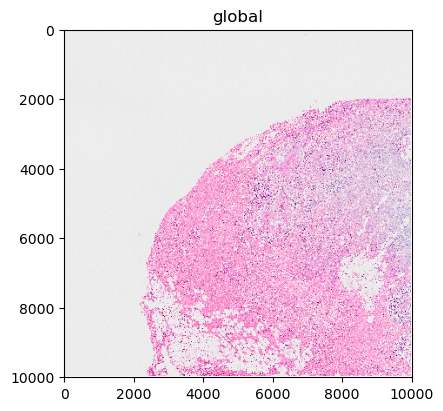

In [13]:
%%time
sdata_cropped.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_full_image", scale="scale0").pl.show(
    "global", dpi=100
)
# the image is automatically rasterized before rendering

Setting `scale="full"` in `pl.render_images()` or `pl.render_labels()` will lead to the scale with highest resolution being selected and no rasterization being performed. Depending on resolution/image size this can lead to long rendering times! In this case, we are looking at the largest image in the SpatialData object ("scale0"). Depending on the machine, the rendering might also run into a memory error. Here, `scale="scale0"` is used to demonstrate high rendering times for images with high resolution.

CPU times: user 3.82 s, sys: 2.5 s, total: 6.33 s
Wall time: 4.69 s


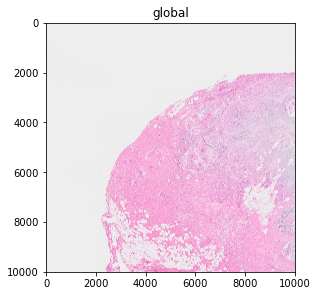

In [14]:
%%time
sdata_cropped.pl.render_images("CytAssist_FFPE_Human_Breast_Cancer_full_image", scale="scale0").pl.show("global")
# using the highest resolution

## 3 Datashader Support for Shapes and Points

We create spatialdata objects with a large number of points/shapes to demonstrate the benefits of using datashader to speed up rendering. 

In [15]:
RNG = np.random.default_rng(seed=42)
sc.pl.set_rcParams_defaults()

def create_large_spatialdata(
    c: int, y: int, x: int, scale_factors: list[int], n_points: int, n_polygons: int, n_multipolygons: int
) -> SpatialData:

    # Create random image cxy
    image_data = RNG.random((c, y, x))
    image = Image2DModel.parse(image_data, dims=["c", "y", "x"])
    multiscale_image = Image2DModel.parse(image_data, dims=["c", "y", "x"], scale_factors=scale_factors)

    # Create random labels yx
    labels_data = RNG.integers(0, 256, size=(y, x)).astype(np.uint8)
    labels = Labels2DModel.parse(labels_data, dims=["y", "x"])
    multiscale_labels = Labels2DModel.parse(labels_data, dims=["y", "x"], scale_factors=scale_factors)

    # Create random xy points
    points_data = RNG.random((n_points, 2)) * [x, y]
    points_df = pd.DataFrame(points_data, columns=["x", "y"])
    points = PointsModel.parse(points_df)

    # Use points to create random circles
    circles = ShapesModel.parse(points_df.to_numpy(), geometry=0, radius=10)

    # Generate random polygons
    def generate_shapes(n, bbox, shape_type):
        minx, miny = bbox[0], bbox[0]
        maxx, maxy = bbox[1], bbox[1]
        shapes = []
        for _ in range(n):
            x = RNG.uniform(minx, maxx)
            y = RNG.uniform(miny, maxy)
            poly = Polygon(
                [
                    (x + RNG.uniform(0, maxx // 4), y + RNG.uniform(0, maxy // 4)),
                    (x + RNG.uniform(0, maxx // 4), y),
                    (x, y + RNG.uniform(0, maxy // 4)),
                ]
            )
            if shape_type == "multipolygon":
                poly2 = translate(poly, xoff=maxx // 4, yoff=maxy // 4)
                shapes.append(MultiPolygon([poly, poly2]))
            else:
                shapes.append(poly)
        return GeoDataFrame({"geometry": shapes})

    polygons = ShapesModel.parse(generate_shapes(n_polygons, (0, max(x, y)), "polygons"))
    multipolygons = ShapesModel.parse(generate_shapes(n_multipolygons, (0, max(x, y)), "multipolygons"))

    return SpatialData(
        images={"image": image, "multiscale_image": multiscale_image},
        labels={"labels": labels, "multiscale_labels": multiscale_labels},
        points={"points": points},
        shapes={"circles": circles, "polygons": polygons, "multipolygons": multipolygons},
    )

In [16]:
def benchmark_single_element(render_function, element, method, number=1, repeat=5):
    return timeit.repeat(lambda: render_function(element=element, method=method).pl.show(), number=number, repeat=repeat)


def benchmark_ds_vs_mpl(to_plot: str, test_numbers: list) -> pd.DataFrame:
    results = []
    dataset_cache = {}

    for tn in test_numbers:
        # Check if dataset for current size is already created
        if tn not in dataset_cache:
            dataset_cache[tn] = create_large_spatialdata(
                c=2,
                y=10000,
                x=10000,
                scale_factors=[2, 2, 2],
                n_points=tn,
                n_polygons=tn,
                n_multipolygons=tn,
            )
        sdata = dataset_cache[tn]
        render_function = (
            sdata.pl.render_shapes if to_plot in {"multipolygons", "polygons", "circles"} else sdata.pl.render_points
        )

        # Store times directly associated with their test number and method
        mpl_times = benchmark_single_element(render_function, to_plot, "matplotlib")
        ds_times = benchmark_single_element(render_function, to_plot, "datashader")

        results.extend(
            (tn, mpl_time, ds_time)
            for mpl_time, ds_time in zip(mpl_times, ds_times)
        )

    return pd.DataFrame(results, columns=["object_num", "mpl_time", "ds_time"])

### 3.1 Polygons
Measure runtime of rendering polygons over 5 repeats for different numbers of polygons.

In [17]:
%%capture
benchmark_results_polygons = benchmark_ds_vs_mpl("polygons", [1, 10, 100, 600, 1_000]) # , 10_000, 100_000, 1_000_000])

In [18]:
def visualise_comparison(benchmark_results, plot_type):
    medians = benchmark_results.groupby("object_num").median().reset_index()

    _, ax = plt.subplots(figsize=(7, 4))

    # Plot median lines
    ax.plot(medians["object_num"], medians["mpl_time"], color="blue", linestyle="--")
    ax.plot(medians["object_num"], medians["ds_time"], color="orange", linestyle="--")

    # Plot scatter points
    ax.scatter(data=benchmark_results, x="object_num", y="mpl_time", color="blue", label="matplotlib")
    ax.scatter(data=benchmark_results, x="object_num", y="ds_time", color="orange", label="datashader")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend(bbox_to_anchor=(1.27, 1.0))
    plt.xlabel(f"Number of {plot_type}")
    plt.ylabel("Rendering Time in Seconds\n(lower is better)")

    plt.show()

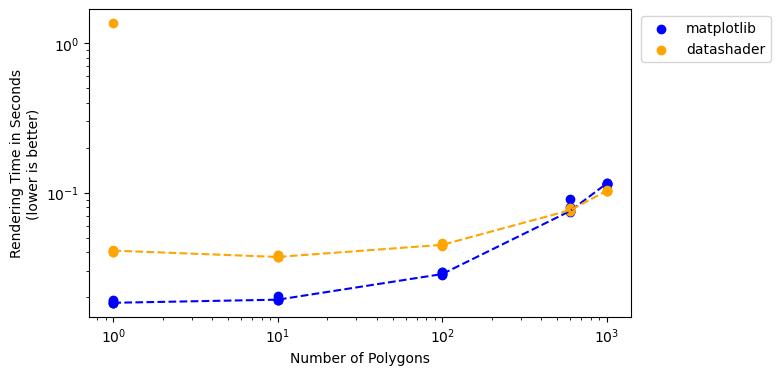

In [19]:
visualise_comparison(benchmark_results_polygons, "Polygons")

We see that for smaller number of polygons, rendering with `matplotlib` is faster than `datashader`. Starting at around 600 polygons, `datashader` is faster.

### 3.2 Multi-Polygons
Measure runtime of rendering multi-polygons over 5 repeats for different numbers of multi-polygons.

In [20]:
%%capture
benchmark_results_multipolygons = benchmark_ds_vs_mpl("multipolygons", [1, 10, 100, 600, 1_000]) # , 10_000, 100_000, 1_000_000])

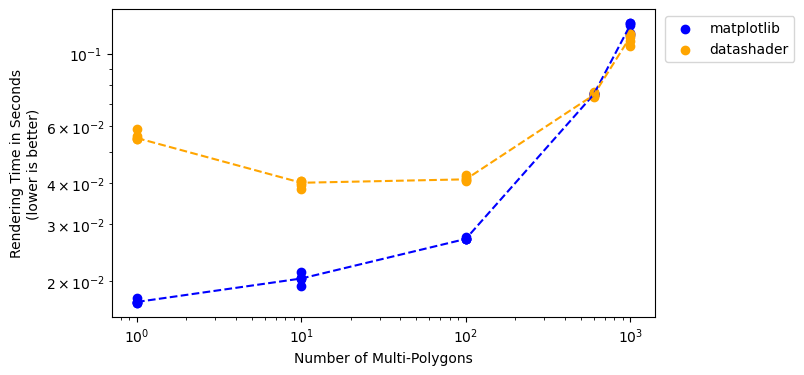

In [21]:
visualise_comparison(benchmark_results_multipolygons, "Multi-Polygons")

Similar to the Polygons, we see that `datashader` performs faster starting at around 600 multi-polygons.

### 3.3 Circles

In [22]:
%%capture
benchmark_results_circles = benchmark_ds_vs_mpl("circles", [1, 10, 100, 300, 1_000]) # , 10_000, 100_000, 1_000_000])

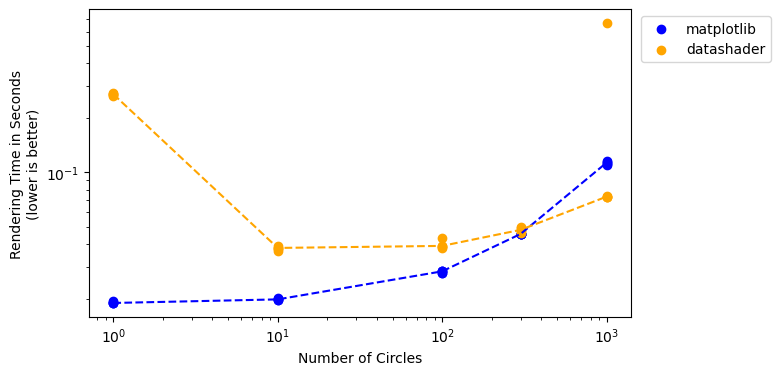

In [23]:
visualise_comparison(benchmark_results_circles, "Circles")

For circles, `datashader` starts to render faster than `matplotlib` starting from around 300 circles.

### 3.4 Points

In [24]:
%%capture
benchmark_results_points = benchmark_ds_vs_mpl("points", [1, 10, 100, 1_000]) #  [1, 100, 10_000, 1_000_000, 100_000_000])

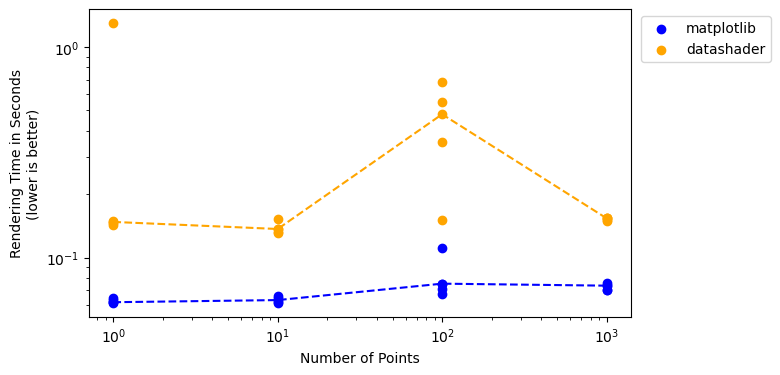

In [25]:
visualise_comparison(benchmark_results_points, "Points")

For points we see that the advantage of using datashader is only visible for larger numbers of items, compared to polygons or circles.